In [2]:
# --- Core libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- ML / Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# --- Optional: for handling imbalance ---
from imblearn.over_sampling import SMOTE

In [9]:
# Load the dataset
df = pd.read_csv("../dataset/data.csv")

# Display first 5 rows
print(df.head())

# Quick info
print(df.info())

# Basic stats
#print(df.describe(include="all"))

   survey_code  age  gender      height     weight        bmi  bmi_estimated  \
0            1   56    Male  173.416872  56.886640  18.915925      18.915925   
1            2   69  Female  163.207380  97.799859  36.716278      36.716278   
2            3   46    Male  177.281966  80.687562  25.673050      25.673050   
3            4   32  Female  172.101255  63.142868  21.318480      21.318480   
4            5   60  Female  163.608816  40.000000  14.943302      14.943302   

   bmi_scaled  bmi_corrected  waist_size  ...  sunlight_exposure  \
0   56.747776      18.989117   72.165130  ...               High   
1  110.148833      36.511417   85.598889  ...               High   
2   77.019151      25.587429   90.295030  ...               High   
3   63.955440      21.177109  100.504211  ...               High   
4   44.829907      14.844299   69.021150  ...               High   

   meals_per_day  caffeine_intake  family_history  pet_owner  \
0              5         Moderate             

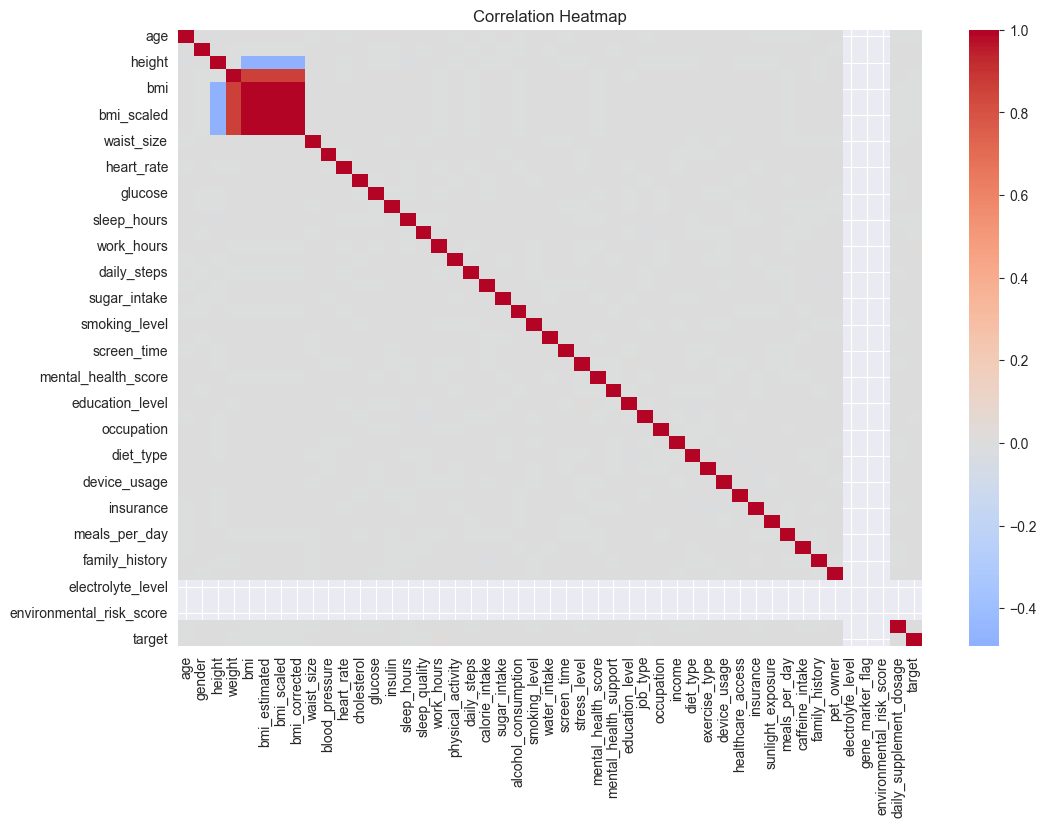

In [14]:
#Correlation heat map
import seaborn as sns
import matplotlib.pyplot as plt

# Encode target temporarily for correlation (healthy=0, at risk=1)
df_temp = df.copy()
df_temp["target"] = LabelEncoder().fit_transform(df_temp["target"])

plt.figure(figsize=(12,8))
sns.heatmap(df_temp.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [10]:
# Drop ID-like column
df = df.drop(columns=["survey_code"])

# --- Handle Missing Values ---
# Numerical: fill with median
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical: fill with mode
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# --- Encode Categorical ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# --- Features & Target ---
X = df.drop(columns=["target"])
y = df["target"]

# --- Train-Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Scaling ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (80000, 46)
Test shape: (20000, 46)


                    Feature  Importance
19           calorie_intake    0.037647
11              cholesterol    0.037548
12                  glucose    0.037516
23             water_intake    0.037490
16               work_hours    0.037426
14              sleep_hours    0.037236
20             sugar_intake    0.037233
8                waist_size    0.037133
45  daily_supplement_dosage    0.037123
9            blood_pressure    0.036922
18              daily_steps    0.036704
24              screen_time    0.036581
10               heart_rate    0.036061
2                    height    0.036053
31                   income    0.035802


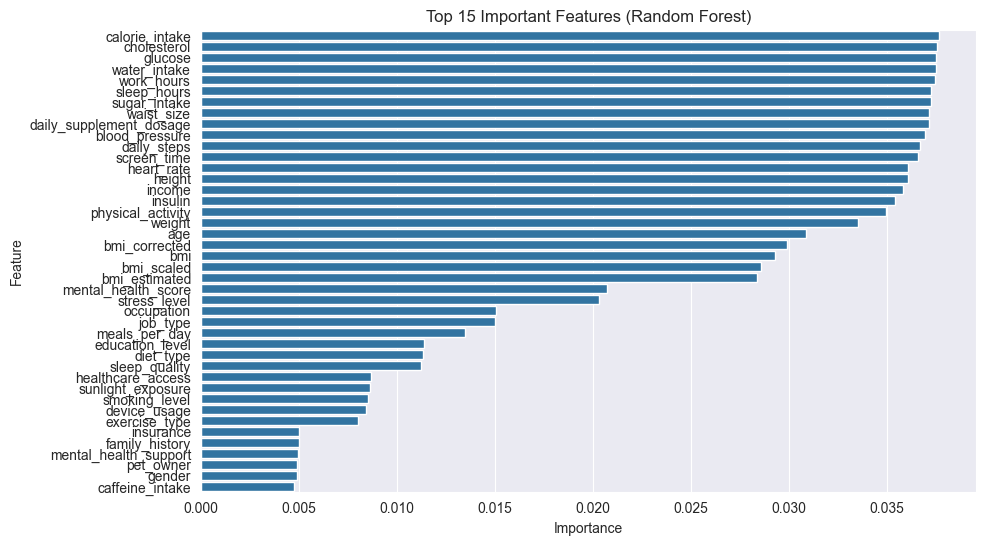

In [22]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

print(feat_imp.head(15))  # Top 15 features

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(42))
plt.title("Top 15 Important Features (Random Forest)")
plt.show()

In [21]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Use only categorical features
cat_features = df.select_dtypes(include=["int64", "float64"]).drop(columns=["target"])
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(cat_features, y)
print("Top 10 Features (Chi-square):")
print(cat_features.columns[selector.get_support()])

ValueError: Input X must be non-negative.

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# --- Model 1: Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("\n🔹 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


🔹 Logistic Regression Results
Accuracy: 0.70095
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5981
           1       0.70      1.00      0.82     14019

    accuracy                           0.70     20000
   macro avg       0.35      0.50      0.41     20000
weighted avg       0.49      0.70      0.58     20000

Confusion Matrix:
 [[    0  5981]
 [    0 14019]]


/Users/thushansenaratne/Desktop/SLIIT/Y3S1/Data Science 2025/IT3051 FDM/Assignment/Project/Disease_Risk_Prediction_from_Daily_Habits/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/thushansenaratne/Desktop/SLIIT/Y3S1/Data Science 2025/IT3051 FDM/Assignment/Project/Disease_Risk_Prediction_from_Daily_Habits/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/thushansenaratne/Desktop/SLIIT/Y3S1/Data Science 2025/IT3051 FDM/Assignment/Project/Disease_Ris

In [13]:
from sklearn.ensemble import RandomForestClassifier

# --- Model 2: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🔹 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


🔹 Random Forest Results
Accuracy: 0.70025
              precision    recall  f1-score   support

           0       0.25      0.00      0.00      5981
           1       0.70      1.00      0.82     14019

    accuracy                           0.70     20000
   macro avg       0.48      0.50      0.41     20000
weighted avg       0.57      0.70      0.58     20000

Confusion Matrix:
 [[    7  5974]
 [   21 13998]]
